# Data Cleaning

## Overview of Dataset

'Report Number': official number of the report upon accident (irrelevant)  
'Local Case Number': assigned case number (irrelevant)  
'Agency Name': the name of the law enforcement or reporting agency (repeated)
'ACRS Report Type': description of the crash (data leakage)  
'Crash Date/Time': exact time of the crash  
'Route Type': different type of traffic roads (i.e. from county to state)  
'Road Name': road names of where the accident took place  
'Cross-Street Type': the street type that conjunct with the accdient road  
'Cross-Street Name': road names of cross-street that conujunct with the accident road  
'Off-Road Description': description of the functionality of the road where accdients took place (i.e. parking lot etc)  
'Municipality': the Municipality where the accident took place (repeated)  
'Related Non-Motorist': indicates if pedestrians, cyclists, or other non-motorists were involved (data leackage)  
'Collision Type': brief description of the how accident happen (data leackage)  
'Weather': categorical description of the weather  
'Surface Condition': condition of the road surface  
'Traffic Control': if traffic regulations such as stop sign exists  
'Driver Substance Abuse': categorise anything any chemicals that can effect the judgement of the drivers  
'Non-Motorist Substance Abuse': categorise anything any chemicals that can effect the judgement of the non-motorist  
'Person ID': number of official identification of the driver (irrelevant)  
'Driver At Fault': whether the driver is at fault for the accident  
'Injury Severity': how severe the injury is (y_variable)  
'Circumstance': a combinagtion of weather and traffic control (repeated)  
'Driver Distracted By': if the driver was distracted, if so and why  
'Drivers License State': where is driver is registered   
'Vehicle ID': chasis of the vehicle (irrelevant)  
'Vehicle Damage Extent': how damanged the vehecle is (data leackage)  
'Vehicle First Impact Location': first contact of the damaged vehicle (data leakage)  
'Vehicle Second Impact Location': second contact of the damanged vehicle (data leakage)  
'Vehicle Body Type': type of the car (i.e. 'PASSENGER CAR' 'PICKUP TRUCK')  
'Vehicle Movement': vehicle movement of the car during the accidient (data leakage)  
'Vehicle Continuing Dir': where the vehicle is going after the accident (data leackage)  
'Vehicle Going Dir': where the vehicle is going before the accident  
'Speed Limit': the posted speed limit on the road where the accident occurred.  
'Driverless Vehicle': Indicates if the vehicle was driverless or autonomous.  
'Parked Vehicle': indicates if a parked vehicle was involved in the accident  
'Vehicle Year': production year of the vehicle  
'Vehicle Make': brand of the vehicle  
'Vehicle Model': a specific model of the vehicle  
'Equipment Problems': Any vehicle equipment issues that might have contributed to the accident  
'Latitude': coordinate  
'Longitude': coordinate  
'Location': coordinate (repeated)  


## data preparation

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')#load dataset


pd.set_option('display.max_columns', None)
drivers = pd.read_csv('Drivers_Data.csv')
# Loop through each column in the DataFrame to print out the unique count and values for each variable
columns_dict = {}
for i in drivers.columns:
    num = len(drivers[i].unique())  
    var = drivers[i].unique()       
    columns_dict[i] = (num, var)


drivers['Timestamp'] = pd.to_datetime(drivers['Crash Date/Time'])
drivers['Month'] = drivers['Timestamp'].dt.month
drivers['Day'] = drivers['Timestamp'].dt.day
drivers['Hour'] = drivers['Timestamp'].dt.hour
drivers['Minute'] = drivers['Timestamp'].dt.minute
drivers['Seconnd'] = drivers['Timestamp'].dt.second

drivers_drop = drivers.drop(['Report Number', 'Local Case Number','Agency Name', 'ACRS Report Type', 'Related Non-Motorist', 'Collision Type',
                             'Person ID', 'Circumstance', 'Vehicle ID', 'Vehicle Damage Extent', 'Vehicle First Impact Location', 'Vehicle Second Impact Location', 
                             'Vehicle Movement', 'Vehicle Continuing Dir', 'Location', 'Crash Date/Time', 'Timestamp','Municipality',
                             'Related Non-Motorist', 'Off-Road Description', 'Non-Motorist Substance Abuse'], axis=1)


# Apply the mapping to the 'Injury Severity' col
injury_severity_mapping = {
    'NO APPARENT INJURY': 0,
    'SUSPECTED MINOR INJURY': 1,
    'POSSIBLE INJURY': 2,
    'SUSPECTED SERIOUS INJURY': 3,
    'FATAL INJURY': 4}

drivers_drop['Injury Severity'] = drivers_drop['Injury Severity'].map(injury_severity_mapping)

print(drivers_drop['Injury Severity'].unique())

# Apply the mapping to the 'Injury Severity' column
weather_mapping = {
    'CLEAR': 1,
    'CLOUDY': 2,
    'RAINING': 3,
    'UNKNOWN': 4,
    'FOGGY': 5,
    'OTHER': 6,
    'SNOW': 7,
    'SLEET': 8,
    'WINTRY MIX': 9,
    'BLOWING SNOW': 10,
    'SEVERE WINDS': 11,
    'BLOWING SAND, SOIL, DIRT': 12
}

# Apply the mapping to the 'weather' column
drivers_drop['Weather'] = drivers_drop['Weather'].map(weather_mapping)

# Check the first few rows to verify the changes
print(drivers_drop['Weather'].unique())

surface_condition_mapping = {
    'UNKNOWN': 1,
    'DRY': 2,
    'WET': 3,
    'WATER(STANDING/MOVING)': 4,
    'MUD, DIRT, GRAVEL': 5,
    'ICE': 6,
    'SNOW': 7,
    'SLUSH': 8,
    'OTHER': 9,
    'OIL': 10,
    'SAND': 11
}

drivers_drop['Surface Condition'] = drivers_drop['Surface Condition'].map(surface_condition_mapping)

print(drivers_drop['Surface Condition'].unique())


[0 1 3 2 4]
[ 1.  2.  3. nan  4.  5.  6.  7.  8.  9. 10. 11. 12.]
[nan  2.  3.  1.  4.  5.  6.  7.  8.  9. 10. 11.]


## KNN

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

# Apply label encoding to categorical variables
LE = LabelEncoder()
df_encoded = drivers_drop.apply(lambda col: LE.fit_transform(col) if col.dtype == 'O' else col)

# Separate features and target variable
X = df_encoded.drop('Injury Severity', axis=1)
y = df_encoded['Injury Severity']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = pd.concat([X_train, y_train], axis=1)
test_dataset = pd.concat([X_test, y_test], axis=1)


# Impute missing values in feature columns
train_impute = train_dataset.copy()
imputer = KNNImputer(n_neighbors=10)
train_imputed = imputer.fit_transform(train_impute)
train_imputed_df = pd.DataFrame(train_imputed, columns=train_impute.columns, index=train_impute.index)
nulls_train = train_imputed_df.isnull().sum().sum()
print("there are", nulls_train, "zeros in the train data")

test_impute = test_dataset.copy()
test_imputed = imputer.fit_transform(test_impute)
test_imputed_df = pd.DataFrame(test_imputed,columns=test_impute.columns, index=test_impute.index)
nulls_test = test_imputed_df.isnull().sum().sum()
print("there are", nulls_test, "zeros in the test data")
df_with_dummies = pd.concat([train_imputed_df, test_imputed_df], axis = 0)




there are 0 zeros in the train data
there are 0 zeros in the test data


# Visualisation

<Axes: >

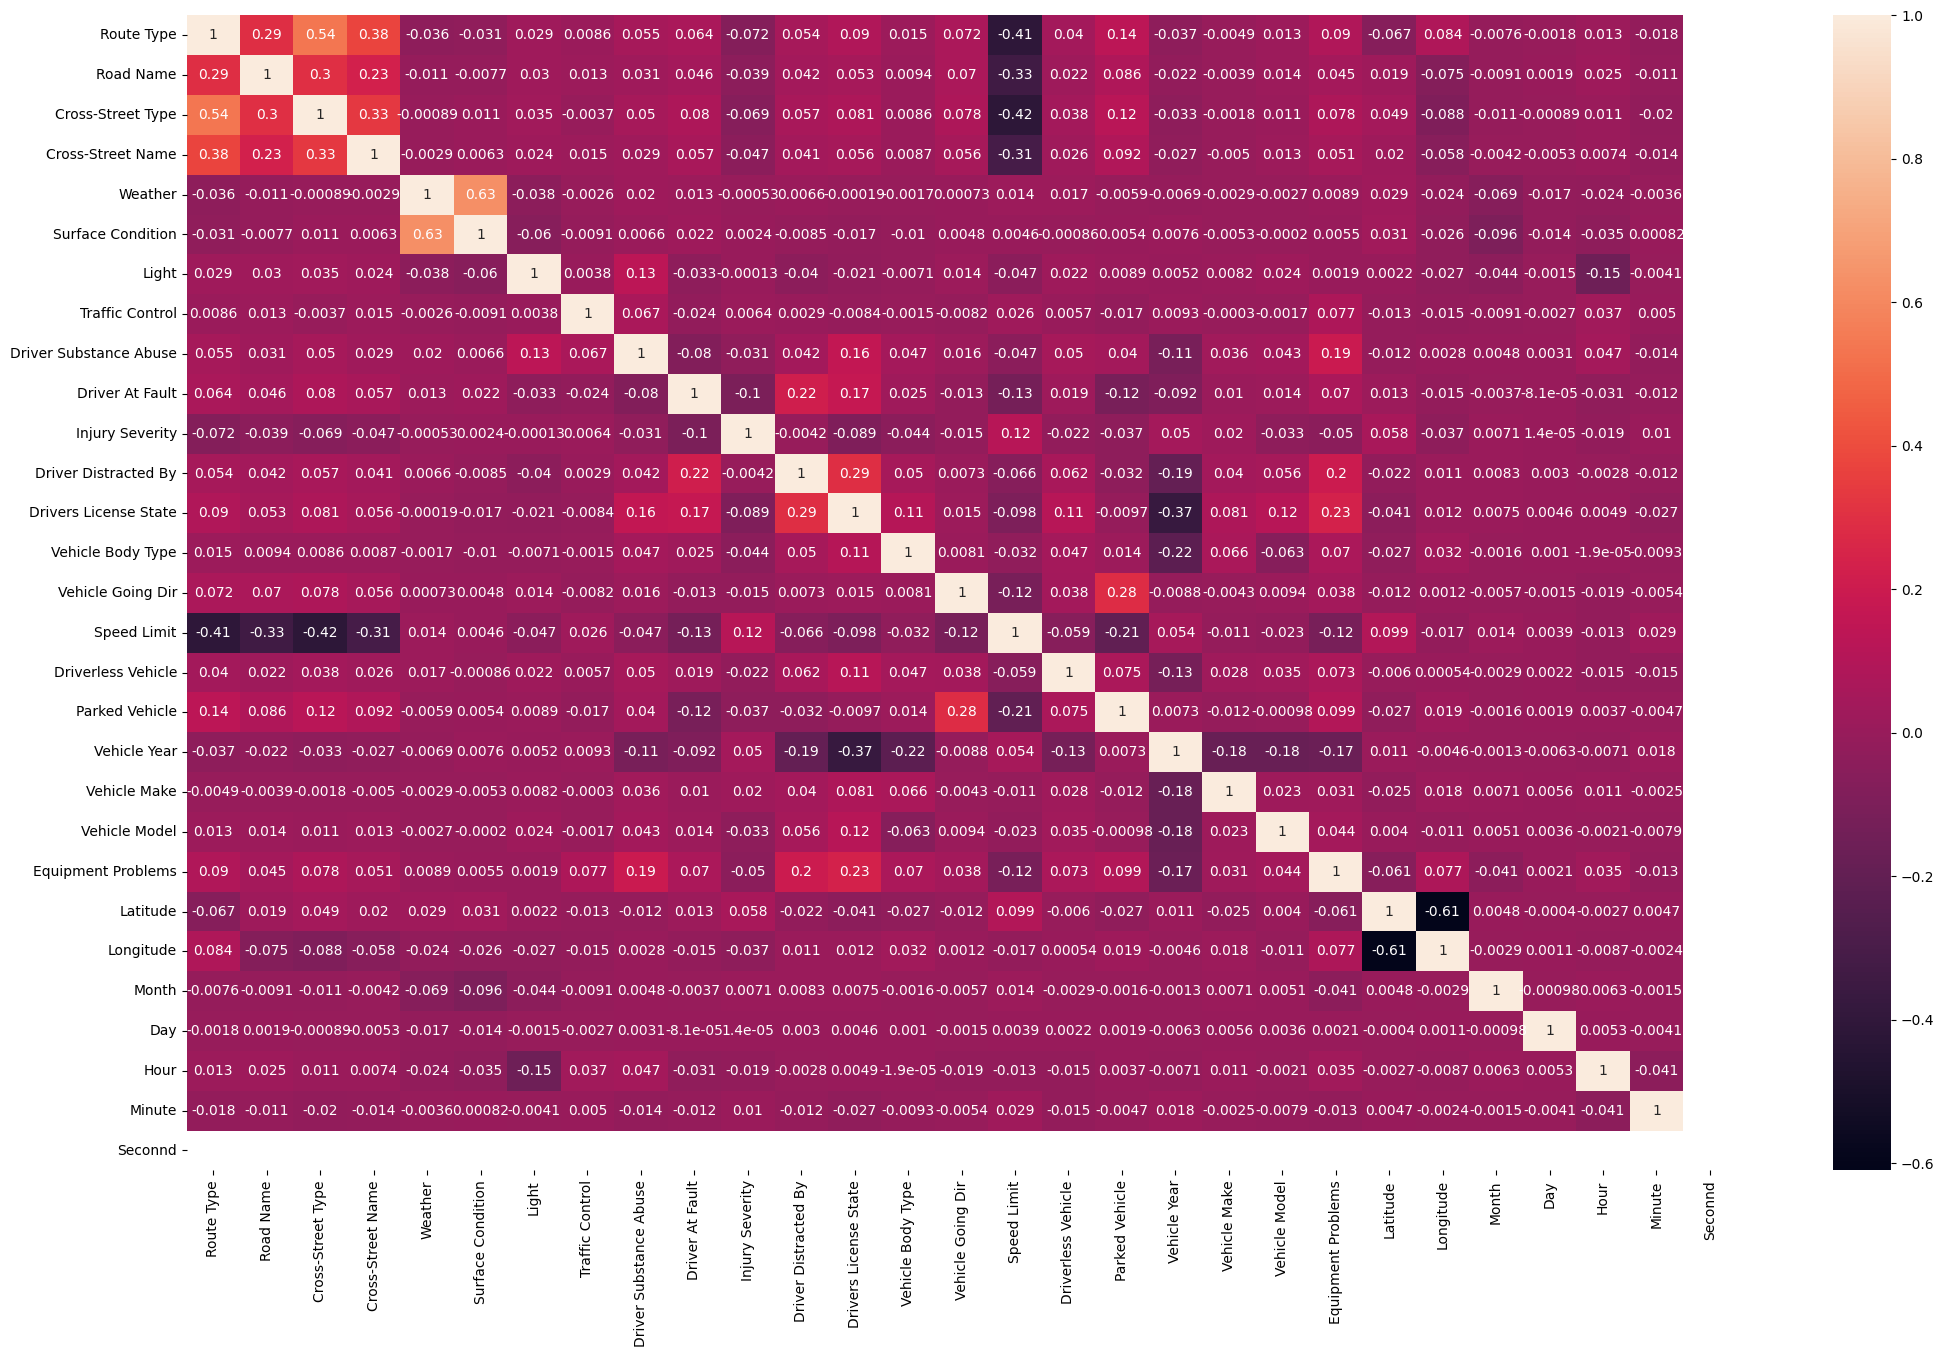

In [20]:
import seaborn as sns
plt.figure(figsize=[25,15])
sns.heatmap(df_encoded.corr(),annot=True)

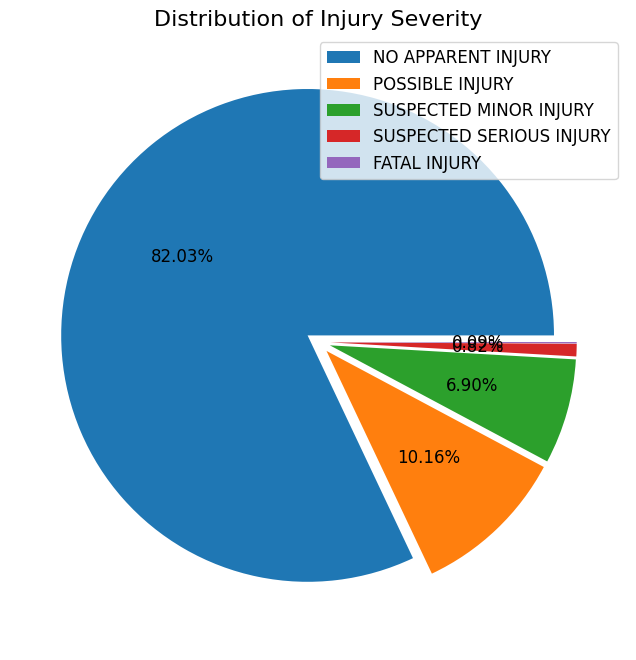

In [64]:
import matplotlib.pyplot as plt

# Get the counts and labels
counts = drivers['Injury Severity'].value_counts()
labels = counts.index

# Create a figure with a larger size
plt.figure(figsize=(12, 8))

# Plot the pie chart with exploded slices
explode = [0.05] * len(labels)  # Explode all slices slightly
plt.pie(x=counts.values,
        labels=None,  # Remove labels directly on the pie
        autopct='%2.2f%%',
        explode=explode,
        textprops={'fontsize': 12})  # Increase font size

# Add legend to show labels
plt.legend(labels, loc="best", fontsize=12)

plt.title('Distribution of Injury Severity', fontsize=16)  # Add title
plt.show()





# Basic random forest

## Baseline

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

# Create a Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed

# Separate features and target variable again
X_train_imputed = train_imputed_df.drop('Injury Severity', axis=1)
y_train_imputed = train_imputed_df['Injury Severity']

# Train the Random Forest classifier
rf_1 = random_forest.fit(X_train_imputed, y_train_imputed)

# Separate features and target variable for the test dataset
X_test_imputed = test_imputed_df.drop('Injury Severity', axis=1)
y_test_imputed = test_imputed_df['Injury Severity']

# Make predictions on the test set
y_pred = rf_1.predict(X_test_imputed)

# Calculate precision and recall
precision = precision_score(y_test_imputed, y_pred, average='weighted')
recall = recall_score(y_test_imputed, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
# Calculate accuracy
accuracy = accuracy_score(y_test_imputed, y_pred)

print("Accuracy:", accuracy)


Precision: 0.7105387590282527
Recall: 0.8195578280700735
Accuracy: 0.8195578280700735


In [101]:
baseline = rf_1.get_params()

print("Parameters of the trained Random Forest classifier:")
print(baseline)

Parameters of the trained Random Forest classifier:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## Hypertune

## Scoring: Accuracy

In [76]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define a Random Forest classifier
random_forest = RandomForestClassifier(random_state=42)

# Define the hyperparameters distributions
param_dist = {
    'n_estimators': [100, 200, 300] + list(randint(400, 500).rvs(10)),  # Specific values + additional random values
    'max_depth': [None] + list(range(5, 20)),  # Maximum depth of the trees
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 20),  # Minimum number of samples required at each leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}

# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(estimator=random_forest, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train_imputed, y_train_imputed)

# Get the best hyperparameters
best_params = random_search.best_params_

# Train the Random Forest classifier with the best hyperparameters
best_rf = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf.predict(X_test_imputed)

# Calculate precision and recall
precision = precision_score(y_test_imputed, y_pred, average='weighted')
recall = recall_score(y_test_imputed, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)

# Calculate accuracy
accuracy = accuracy_score(y_test_imputed, y_pred)
print("Accuracy:", accuracy)




Precision: 0.6979247755377641
Recall: 0.8200807646494872
Accuracy: 0.8200807646494872


In [79]:
best_params_accuracy = best_params
print(best_params_accuracy)

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100}


In [85]:
best_rf = RandomForestClassifier(max_depth=None, max_features='sqrt', min_samples_leaf=2, min_samples_split=6, n_estimators=100, random_state=42)

# Train the Random Forest classifier on your data
best_rf.fit(X_train_imputed, y_train_imputed)

# Make predictions on the test set
y_pred = best_rf.predict(X_test_imputed)

# Calculate precision and recall
precision = precision_score(y_test_imputed, y_pred, average='weighted')
recall = recall_score(y_test_imputed, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)

# Calculate accuracy
accuracy = accuracy_score(y_test_imputed, y_pred)
print("Accuracy:", accuracy)


Precision: 0.6979247755377641
Recall: 0.8200807646494872
Accuracy: 0.8200807646494872


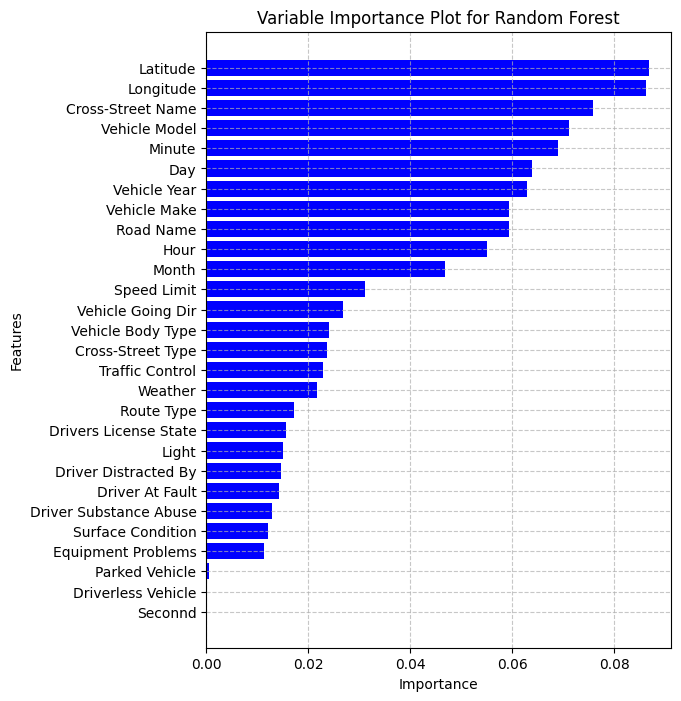

In [96]:

def plot_variable_importance(model, X_train):
    # Extract feature importances and corresponding feature names
    feature_importances = model.feature_importances_
    feature_names = X_train.columns
    
    # Create a DataFrame to store importances and names, then sort by importances
    importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
    importance_df = importance_df.sort_values(by="Importance", ascending=False)
    
    # Plot variable importance
    plt.figure(figsize=(6, 8))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="blue")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title("Variable Importance Plot for Random Forest")
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Call the function to plot variable importance
plot_variable_importance(best_rf, X_train_imputed)  # Assuming 'best_rf' is your trained Random Forest model


## Scoring: Recall

In [81]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define a Random Forest classifier
random_forest = RandomForestClassifier(random_state=42)

# Define the hyperparameters distributions
# Define the hyperparameters distributions
param_dist = {
    'n_estimators': [100, 200, 300] + list(randint(400, 500).rvs(10)),  # Specific values + additional random values
    'max_depth': [None] + list(range(5, 20)),  # Maximum depth of the trees
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 20),  # Minimum number of samples required at each leaf node
    'max_features': ['sqrt', 'log2', 'None']  # Number of features to consider when looking for the best split, 'auto' replaced with 'sqrt'
}


# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(estimator=random_forest, param_distributions=param_dist, n_iter=100, cv=5, scoring='recall', random_state=42)
random_search.fit(X_train_imputed, y_train_imputed)

# Get the best hyperparameters
best_params = random_search.best_params_

# Train the Random Forest classifier with the best hyperparameters
best_rf = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf.predict(X_test_imputed)

# Calculate precision and recall
precision = precision_score(y_test_imputed, y_pred, average='weighted')
recall = recall_score(y_test_imputed, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)

# Calculate accuracy
accuracy = accuracy_score(y_test_imputed, y_pred)
print("Accuracy:", accuracy)

Precision: 0.6726277639752608
Recall: 0.8201388687138665
Accuracy: 0.8201388687138665


In [83]:
best_params_recall = best_params
print(best_params_recall)


{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 12, 'n_estimators': 406}


# LASSO

Best Alpha: 1e-05


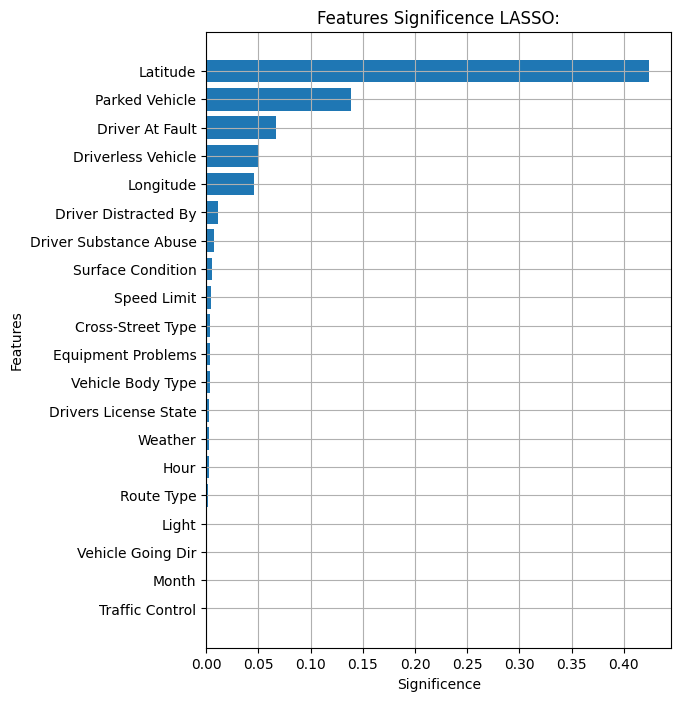

Features Significence LASSO:


In [95]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


best_alphas = []

# Create a dictionary to store feature importance for each feature
feature_importance = {}
alphas = np.arange(0.00001, 3, 0.001)

# Standardize the dataset
pipeline = Pipeline([("scaler", StandardScaler()),
                     ("lasso", LassoCV(alphas=alphas, cv=5))])

pipeline.fit(X_train_imputed, y_train_imputed)

# Get the best alpha for this region
best_alpha = pipeline.named_steps['lasso'].alpha_
best_alphas.append(best_alpha)

print(f"Best Alpha:", best_alpha)

# Create a Lasso model with the best alpha
lasso1 = Lasso(alpha=best_alpha)
lasso1.fit(X_train_imputed, y_train_imputed)

# Make coefficients positive.
lasso1_coef = np.abs(lasso1.coef_)

# Sort coefficients in descending order of importance
sorted_indices = np.argsort(lasso1_coef)[::-1]
sorted_lasso1_coef = lasso1_coef[sorted_indices]
sorted_names = X_train_imputed.columns[sorted_indices]

# Select the top 10 most important features
top_features = sorted_names[:20]
top_importances = sorted_lasso1_coef[:20]

# Importance Plot for the top 10 features
plt.figure(figsize=(6, 8))
plt.barh(top_features, top_importances) 
plt.grid()
plt.title(f"Features Significence LASSO:")
plt.xlabel("Significence")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()

# Average importance for all features
average_importance = {feature: np.mean(coefs) for feature, coefs in feature_importance.items()}

# Sort features by average importance and select the top 10
top_features = sorted(average_importance.keys(), key=lambda x: average_importance[x], reverse=True)[:10]

print("Features Significence LASSO:")
for feature in top_features:
    print(f"best alpha is: {average_importance[feature]}")


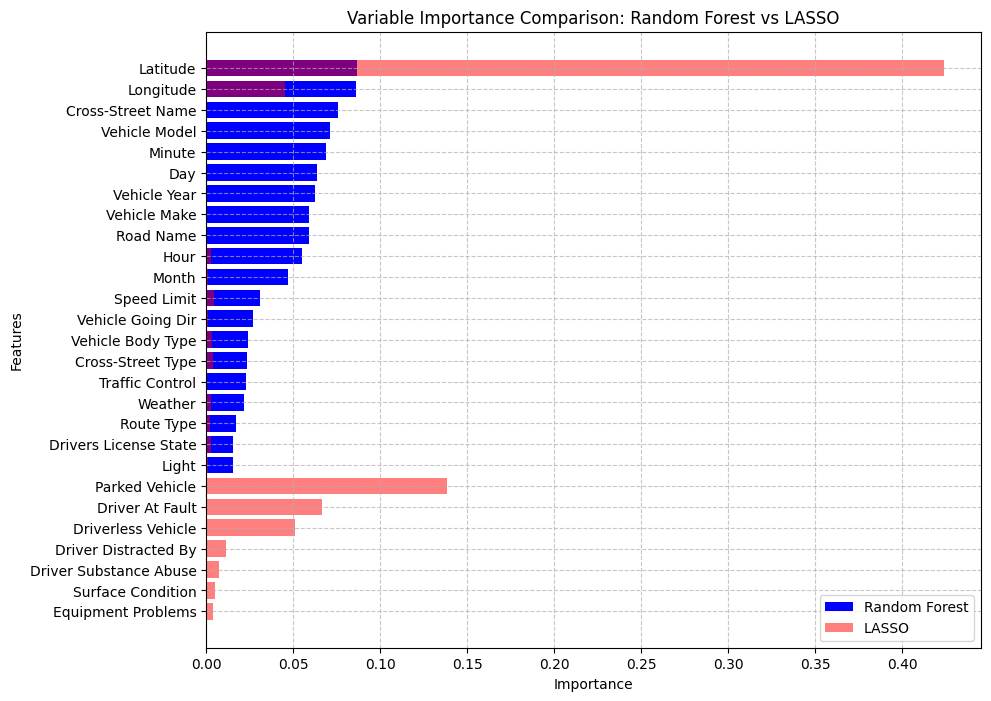

In [99]:
import matplotlib.pyplot as plt

def plot_variable_importance(model_rf, model_lasso, X_train):
    # Extract feature importances and corresponding feature names for Random Forest
    feature_importances_rf = model_rf.feature_importances_
    feature_names_rf = X_train.columns
    
    # Extract feature importances and corresponding feature names for LASSO
    feature_importances_lasso = np.abs(model_lasso.coef_)
    feature_names_lasso = X_train.columns
    
    # Sort feature importances and feature names for Random Forest
    sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]
    sorted_feature_importances_rf = feature_importances_rf[sorted_indices_rf]
    sorted_feature_names_rf = feature_names_rf[sorted_indices_rf]
    
    # Sort feature importances and feature names for LASSO
    sorted_indices_lasso = np.argsort(feature_importances_lasso)[::-1]
    sorted_feature_importances_lasso = feature_importances_lasso[sorted_indices_lasso]
    sorted_feature_names_lasso = feature_names_lasso[sorted_indices_lasso]
    
    # Plot variable importance
    plt.figure(figsize=(10, 8))
    
    # Plot Random Forest importance
    plt.barh(sorted_feature_names_rf[:20], sorted_feature_importances_rf[:20], color="blue", label="Random Forest")
    
    # Plot LASSO importance
    plt.barh(sorted_feature_names_lasso[:20], sorted_feature_importances_lasso[:20], color="red", label="LASSO", alpha=0.5)
    
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title("Variable Importance Comparison: Random Forest vs LASSO")
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

# Call the function to plot variable importance
plot_variable_importance(best_rf, lasso1, X_train_imputed)  # Assuming 'best_rf' is your trained Random Forest model and 'lasso1' is your trained LASSO model


In [51]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed

# Separate features and target variable again
X_train_imputed_lasso = train_imputed_df[sorted_names[:20]]
X_test_imputed_lasso = test_imputed_df[sorted_names[:20]]

# Train the Random Forest classifier
rf_2 = random_forest.fit(X_train_imputed_lasso, y_train_imputed)

y_pred = rf_2.predict(X_test_imputed_lasso)

# Calculate precision and recall
precision = precision_score(y_test_imputed, y_pred, average='weighted')
recall = recall_score(y_test_imputed, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
# Calculate accuracy
accuracy = accuracy_score(y_test_imputed, y_pred)

print("Accuracy:", accuracy)

Precision: 0.706625152106351
Recall: 0.814764242758781
Accuracy: 0.814764242758781


In [84]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define a Random Forest classifier
random_forest = RandomForestClassifier(random_state=42)

# Define the hyperparameters distributions
# Define the hyperparameters distributions
param_dist = {
    'n_estimators': [100, 200, 300] + list(randint(400, 500).rvs(10)),  # Specific values + additional random values
    'max_depth': [None] + list(range(5, 20)),  # Maximum depth of the trees
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 20),  # Minimum number of samples required at each leaf node
    'max_features': ['sqrt', 'log2', 'None']  # Number of features to consider when looking for the best split, 'auto' replaced with 'sqrt'
}


# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(estimator=random_forest, param_distributions=param_dist, n_iter=100, cv=5, scoring='recall', random_state=42)
random_search.fit(X_train_imputed_lasso, y_train_imputed)

# Get the best hyperparameters
best_params = random_search.best_params_

# Train the Random Forest classifier with the best hyperparameters
best_rf = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf.predict(X_test_imputed_lasso)

# Calculate precision and recall
precision = precision_score(y_test_imputed, y_pred, average='weighted')
recall = recall_score(y_test_imputed, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)

# Calculate accuracy
accuracy = accuracy_score(y_test_imputed, y_pred)
print("Accuracy:", accuracy)

KeyboardInterrupt: 

# Try dataset with more than 2 incidents on a road

In [68]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')#load dataset


pd.set_option('display.max_columns', None)
drivers = pd.read_csv('Drivers_Data.csv')
# Loop through each column in the DataFrame to print out the unique count and values for each variable
columns_dict = {}
for i in drivers.columns:
    num = len(drivers[i].unique())  
    var = drivers[i].unique()       
    columns_dict[i] = (num, var)


drivers['Timestamp'] = pd.to_datetime(drivers['Crash Date/Time'])
drivers['Month'] = drivers['Timestamp'].dt.month
drivers['Day'] = drivers['Timestamp'].dt.day
drivers['Hour'] = drivers['Timestamp'].dt.hour
drivers['Minute'] = drivers['Timestamp'].dt.minute
drivers['Seconnd'] = drivers['Timestamp'].dt.second

drivers_drop = drivers.drop(['Report Number', 'Local Case Number','Agency Name', 'ACRS Report Type', 'Related Non-Motorist', 'Collision Type',
                             'Person ID', 'Circumstance', 'Vehicle ID', 'Vehicle Damage Extent', 'Vehicle First Impact Location', 'Vehicle Second Impact Location', 
                             'Vehicle Movement', 'Vehicle Continuing Dir', 'Location', 'Crash Date/Time', 'Timestamp','Municipality',
                             'Related Non-Motorist', 'Off-Road Description', 'Non-Motorist Substance Abuse'], axis=1)


# Apply the mapping to the 'Injury Severity' col
injury_severity_mapping = {
    'NO APPARENT INJURY': 0,
    'SUSPECTED MINOR INJURY': 1,
    'POSSIBLE INJURY': 2,
    'SUSPECTED SERIOUS INJURY': 3,
    'FATAL INJURY': 4}

drivers_drop['Injury Severity'] = drivers_drop['Injury Severity'].map(injury_severity_mapping)

print(drivers_drop['Injury Severity'].unique())

# Apply the mapping to the 'Injury Severity' column
weather_mapping = {
    'CLEAR': 1,
    'CLOUDY': 2,
    'RAINING': 3,
    'UNKNOWN': 4,
    'FOGGY': 5,
    'OTHER': 6,
    'SNOW': 7,
    'SLEET': 8,
    'WINTRY MIX': 9,
    'BLOWING SNOW': 10,
    'SEVERE WINDS': 11,
    'BLOWING SAND, SOIL, DIRT': 12
}

# Apply the mapping to the 'weather' column
drivers_drop['Weather'] = drivers_drop['Weather'].map(weather_mapping)

# Check the first few rows to verify the changes
print(drivers_drop['Weather'].unique())

surface_condition_mapping = {
    'UNKNOWN': 1,
    'DRY': 2,
    'WET': 3,
    'WATER(STANDING/MOVING)': 4,
    'MUD, DIRT, GRAVEL': 5,
    'ICE': 6,
    'SNOW': 7,
    'SLUSH': 8,
    'OTHER': 9,
    'OIL': 10,
    'SAND': 11
}

drivers_drop['Surface Condition'] = drivers_drop['Surface Condition'].map(surface_condition_mapping)

print(drivers_drop['Surface Condition'].unique())

# additional twist
road_name_counts = drivers_drop['Road Name'].value_counts()
valid_road_names = road_name_counts[road_name_counts >= 4].index
drivers_drop = drivers_drop[drivers_drop['Road Name'].isin(valid_road_names)]




[0 1 3 2 4]
[ 1.  2.  3. nan  4.  5.  6.  7.  8.  9. 10. 11. 12.]
[nan  2.  3.  1.  4.  5.  6.  7.  8.  9. 10. 11.]


In [69]:
print(drivers_drop.columns)

Index(['Route Type', 'Road Name', 'Cross-Street Type', 'Cross-Street Name',
       'Weather', 'Surface Condition', 'Light', 'Traffic Control',
       'Driver Substance Abuse', 'Driver At Fault', 'Injury Severity',
       'Driver Distracted By', 'Drivers License State', 'Vehicle Body Type',
       'Vehicle Going Dir', 'Speed Limit', 'Driverless Vehicle',
       'Parked Vehicle', 'Vehicle Year', 'Vehicle Make', 'Vehicle Model',
       'Equipment Problems', 'Latitude', 'Longitude', 'Month', 'Day', 'Hour',
       'Minute', 'Seconnd'],
      dtype='object')


In [70]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

# Apply label encoding to categorical variables
LE = LabelEncoder()
df_encoded = drivers_drop.apply(lambda col: LE.fit_transform(col) if col.dtype == 'O' else col)

# Separate features and target variable
X = df_encoded.drop('Injury Severity', axis=1)
y = df_encoded['Injury Severity']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = pd.concat([X_train, y_train], axis=1)
test_dataset = pd.concat([X_test, y_test], axis=1)


# Impute missing values in feature columns
train_impute = train_dataset.copy()
imputer = KNNImputer(n_neighbors=10)
train_imputed = imputer.fit_transform(train_impute)
train_imputed_df = pd.DataFrame(train_imputed, columns=train_impute.columns, index=train_impute.index)
nulls_train = train_imputed_df.isnull().sum().sum()
print("there are", nulls_train, "zeros in the train data")

test_impute = test_dataset.copy()
test_imputed = imputer.fit_transform(test_impute)
test_imputed_df = pd.DataFrame(test_imputed,columns=test_impute.columns, index=test_impute.index)
nulls_test = test_imputed_df.isnull().sum().sum()
print("there are", nulls_test, "zeros in the test data")
df_with_dummies = pd.concat([train_imputed_df, test_imputed_df], axis = 0)




there are 0 zeros in the train data
there are 0 zeros in the test data


In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

# Create a Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed

# Separate features and target variable again
X_train_imputed = train_imputed_df.drop('Injury Severity', axis=1)
y_train_encoded = train_imputed_df['Injury Severity']

# Train the Random Forest classifier
rf_3 = random_forest.fit(X_train_imputed, y_train_encoded)

# Separate features and target variable for the test dataset
X_test_imputed = test_imputed_df.drop('Injury Severity', axis=1)
y_test_encoded = test_imputed_df['Injury Severity']

# Make predictions on the test set
y_pred = rf_3.predict(X_test_imputed)

# Calculate precision and recall
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)

print("Accuracy:", accuracy)

Precision: 0.7105387590282527
Recall: 0.8195578280700735
Accuracy: 0.8195578280700735


In [14]:
from sklearn.impute import KNNImputer


drivers_encoded = pd.get_dummies(drivers_drop, 
                                 columns=['Route Type', 'Road Name', 'Cross-Street Type', 'Cross-Street Name',
                                        'Light', 'Traffic Control',
                                        'Driver Substance Abuse', 'Driver At Fault',
                                        'Driver Distracted By', 'Drivers License State', 'Vehicle Body Type',
                                        'Vehicle Going Dir', 'Driverless Vehicle', 'Parked Vehicle',
                                        'Vehicle Make', 'Vehicle Model', 'Equipment Problems'], drop_first=True)

# Assuming drivers_encoded is defined
X = drivers_encoded.drop('Injury Severity', axis=1)
y = drivers_encoded['Injury Severity']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Concatenate X_train with y_train, and X_test with y_test
train_dataset = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
test_dataset = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)

# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=10)

# Impute missing values in the train dataset
train_imputed = imputer.fit_transform(train_dataset)
train_imputed_df = pd.DataFrame(train_imputed, columns=train_dataset.columns, index=train_dataset.index)

# Check for nulls in the train dataset
nulls_train = train_imputed_df.isnull().sum().sum()
print("There are", nulls_train, "nulls in the train data")

# Impute missing values in the test dataset using the same imputer (transform only)
test_imputed = imputer.transform(test_dataset)
test_imputed_df = pd.DataFrame(test_imputed, columns=test_dataset.columns, index=test_dataset.index)

# Check for nulls in the test dataset
nulls_test = test_imputed_df.isnull().sum().sum()
print("There are", nulls_test, "nulls in the test data")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

# Train multiple Random Forest models with different configurations
models = [
    RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42),
    RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42),
    RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)
]

plt.figure(figsize=(8, 6))

# Plot ROC curves for each model
for model in models:
    model.fit(X_train, y_train)  # Assuming X_train and y_train are your training data
    y_scores = model.predict_proba(X_test)[:, 1]  # Get predicted probabilities for positive class
    fpr, tpr, _ = roc_curve(y_test, y_scores)  # Calculate ROC curve
    roc_auc = auc(fpr, tpr)  # Calculate AUC score
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')  # Plot ROC curve

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

# Plot ROC curves for each model
for i, rf_model in enumerate([rf_1, rf_2, rf_3]):
    y_scores = rf_model.predict_proba(X_test_imputed)[:, 1]  # Get predicted probabilities for positive class
    fpr, tpr, _ = roc_curve(y_test_imputed, y_scores)  # Calculate ROC curve
    roc_auc = auc(fpr, tpr)  # Calculate AUC score
    plt.plot(fpr, tpr, label=f'RF_{i+1} (AUC = {roc_auc:.2f}')  # Plot ROC curve

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


ValueError: multiclass format is not supported

<Figure size 800x600 with 0 Axes>

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

plt.figure(figsize=(8, 6))

# Plot one-vs-all ROC curves for each class
for i in range(num_classes):
    y_test_binary = label_binarize(y_test, classes=[i])  # Convert the target variable to binary format
    y_scores = rf_model.predict_proba(X_test)[:, i]  # Get predicted probabilities for class i
    fpr, tpr, _ = roc_curve(y_test_binary, y_scores)  # Calculate ROC curve
    roc_auc = auc(fpr, tpr)  # Calculate AUC score
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')  # Plot ROC curve

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-All ROC Curve Comparison')
plt.legend()
plt.show()


NameError: name 'num_classes' is not defined

<Figure size 800x600 with 0 Axes>